In [50]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [51]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [52]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [53]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


/Users/pragathi.vetrivelmurugan/Desktop/TSAI/TSAI-Assignment-6/tsai_env/lib/python3.13/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


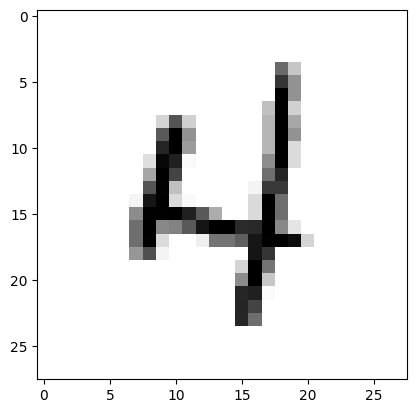

In [54]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


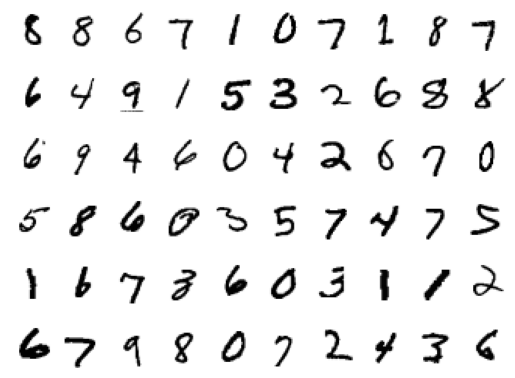

In [55]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

#### Model Definition

In [56]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CONVOLUTION BLOCK 1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=0),
            nn.ReLU()
        )# 26X26X32
        self.convblock2 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.ReLU()
        )# 24X24X64

        # TRANSITION BLOCK 1
        # self.pool1 = nn.MaxPool2d(2, 2)
        # self.convblock3 = nn.Sequential(
        #     nn.Conv2d(64, 64, 1),
        #     nn.ReLU()
        # )#12X12X64

        # # OUTPUT BLOCK
        # self.convblock4 = nn.Sequential(
        #     nn.Conv2d(64, 32, 3, padding=0),
        #     nn.ReLU()
        # ) # 10X10X32

        self.fc1 = nn.Linear(24*24*64, 1028)
        self.fc2 = nn.Linear(1028, 10)
        #self.fc2 = nn.Linear(10*10*1, 10)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = x.view(-1, 24*24*64)  # Flatten the tensor
        x = self.fc1(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

#### Model Summary

In [57]:
!pip install torchsummary tqdm
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
cpu
cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
              ReLU-4           [-1, 64, 24, 24]               0
            Linear-5                 [-1, 1028]      37,897,220
            Linear-6                   [-1, 10]          10,290
Total params: 37,926,326
Trainable params: 37,926,326
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.90
Params size (MB): 144.68
Estimated Total Size (MB): 14

#### Model Training and Testing

In [58]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [59]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.0023657511919736862 Batch_id=937 Accuracy=95.23: 100%|█| 938/938 [02:24<0




Test set: Average loss: 0.0561, Accuracy: 9821/10000 (98.21%)

EPOCH: 1


Loss=0.003380001289770007 Batch_id=937 Accuracy=98.35: 100%|█| 938/938 [02:28<00




Test set: Average loss: 0.0404, Accuracy: 9861/10000 (98.61%)

EPOCH: 2


Loss=0.005407964810729027 Batch_id=937 Accuracy=98.85: 100%|█| 938/938 [02:16<00




Test set: Average loss: 0.0387, Accuracy: 9872/10000 (98.72%)

EPOCH: 3


Loss=0.010393925942480564 Batch_id=937 Accuracy=99.10: 100%|█| 938/938 [02:15<00




Test set: Average loss: 0.0418, Accuracy: 9855/10000 (98.55%)

EPOCH: 4


Loss=0.014830994419753551 Batch_id=937 Accuracy=99.42: 100%|█| 938/938 [02:20<00




Test set: Average loss: 0.0429, Accuracy: 9856/10000 (98.56%)

EPOCH: 5


Loss=0.0009368071332573891 Batch_id=937 Accuracy=99.54: 100%|█| 938/938 [02:18<0




Test set: Average loss: 0.0452, Accuracy: 9862/10000 (98.62%)

EPOCH: 6


Loss=0.04085760936141014 Batch_id=937 Accuracy=99.68: 100%|█| 938/938 [02:31<00:




Test set: Average loss: 0.0436, Accuracy: 9885/10000 (98.85%)

EPOCH: 7


Loss=0.006714309565722942 Batch_id=937 Accuracy=99.73: 100%|█| 938/938 [02:17<00




Test set: Average loss: 0.0454, Accuracy: 9870/10000 (98.70%)

EPOCH: 8


Loss=0.005669977981597185 Batch_id=937 Accuracy=99.80: 100%|█| 938/938 [02:15<00




Test set: Average loss: 0.0496, Accuracy: 9878/10000 (98.78%)

EPOCH: 9


Loss=0.0005120097193866968 Batch_id=937 Accuracy=99.87: 100%|█| 938/938 [02:21<0




Test set: Average loss: 0.0477, Accuracy: 9882/10000 (98.82%)

EPOCH: 10


Loss=0.002046323847025633 Batch_id=937 Accuracy=99.92: 100%|█| 938/938 [02:14<00




Test set: Average loss: 0.0537, Accuracy: 9882/10000 (98.82%)

EPOCH: 11


Loss=0.0006758322706446052 Batch_id=937 Accuracy=99.97: 100%|█| 938/938 [02:16<0




Test set: Average loss: 0.0512, Accuracy: 9878/10000 (98.78%)

EPOCH: 12


Loss=3.7735433124908013e-06 Batch_id=937 Accuracy=100.00: 100%|█| 938/938 [02:18




Test set: Average loss: 0.0522, Accuracy: 9886/10000 (98.86%)

EPOCH: 13


Loss=5.561587386182509e-06 Batch_id=937 Accuracy=100.00: 100%|█| 938/938 [02:18<




Test set: Average loss: 0.0546, Accuracy: 9889/10000 (98.89%)

EPOCH: 14


Loss=0.0005918908282183111 Batch_id=937 Accuracy=100.00: 100%|█| 938/938 [02:18<




Test set: Average loss: 0.0557, Accuracy: 9889/10000 (98.89%)



Selected random misclassified image with true label: 5
Image shape: torch.Size([1, 1, 28, 28])
convblock1 output shape: torch.Size([1, 32, 26, 26])
convblock2 output shape: torch.Size([1, 64, 24, 24])
fc1 output shape: torch.Size([1, 1028])
fc2 output shape: torch.Size([1, 10])
Predicted label: 3


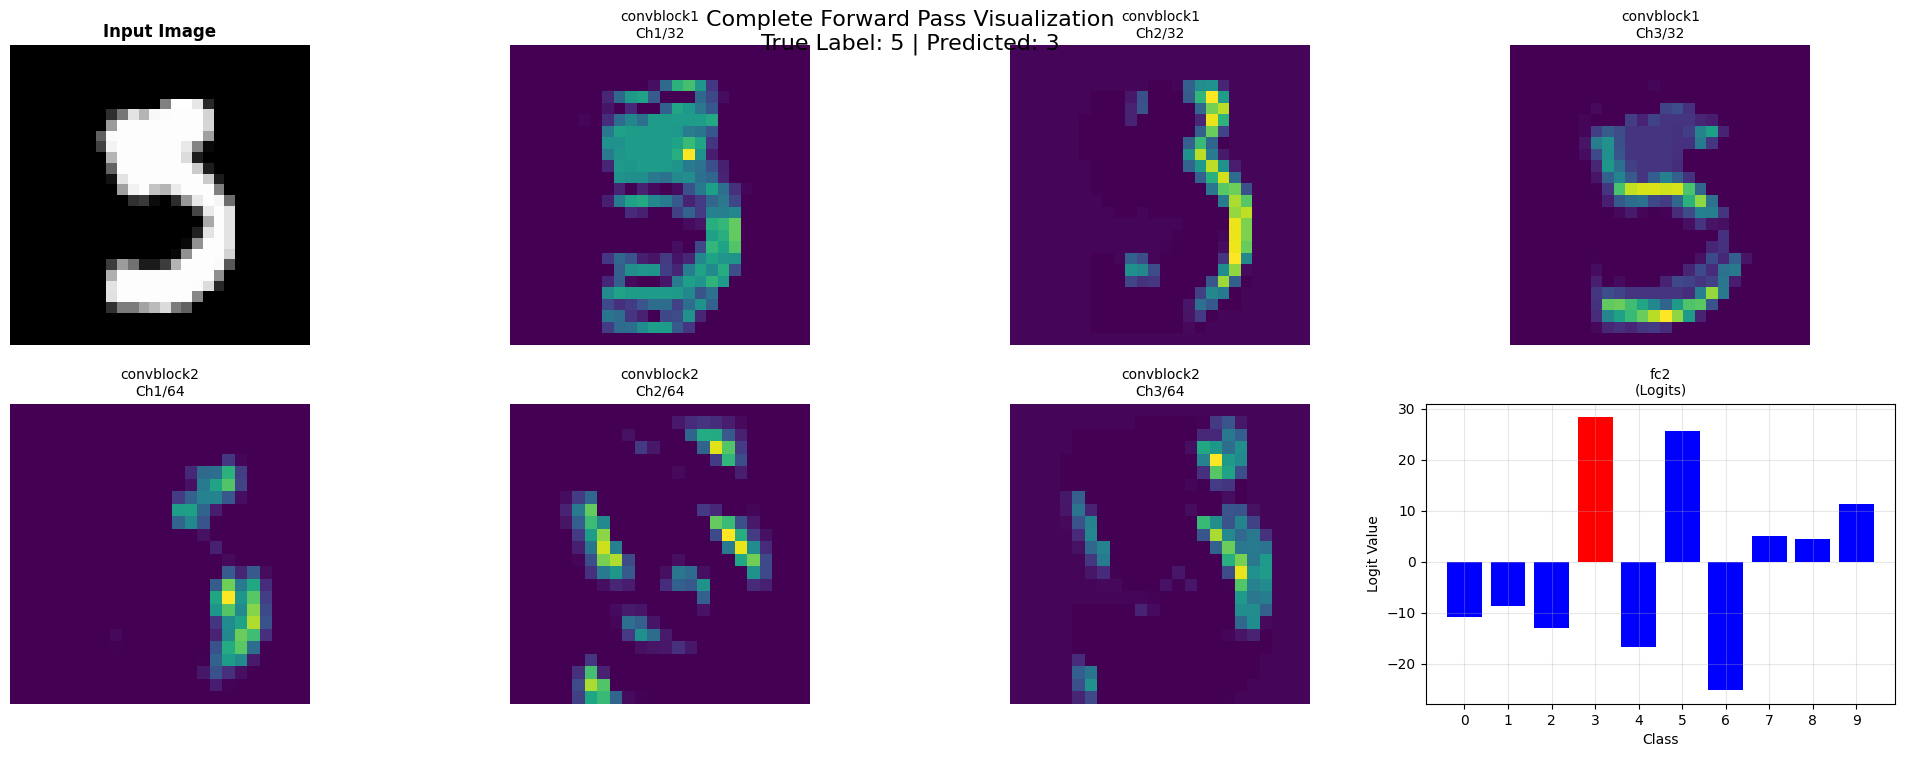


DETAILED LAYER OUTPUT STATISTICS

convblock1 (Conv Layer):
  Shape: torch.Size([1, 32, 26, 26])
  Mean activation: 0.2245
  Std activation: 0.5039
  Min: 0.0000, Max: 4.8425
  Sparsity (% zeros): 55.49%

convblock2 (Conv Layer):
  Shape: torch.Size([1, 64, 24, 24])
  Mean activation: 0.1100
  Std activation: 0.3754
  Min: 0.0000, Max: 5.9690
  Sparsity (% zeros): 80.47%

fc1 (Conv Layer):
  Shape: torch.Size([1, 1028])
  Mean activation: 0.0510
  Std activation: 1.0794
  Min: -3.7978, Max: 3.5695
  Sparsity (% zeros): 0.00%

fc2 (FC Layer):
  Shape: torch.Size([1, 10])
  Mean: 0.0520
  Std: 17.0554
  Min: -25.1792, Max: 28.3100
  Predicted class: 3 (logit: 28.3100)


In [63]:
# Visualize the complete forward pass through all layers
def visualize_complete_forward_pass(model, device, test_loader):
    """
    Choose a random misclassified image from test set and visualize outputs through all layers
    """
    model.eval()
    
    # Find a random misclassified sample
    sample_image = None
    true_label = None
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            # Find misclassified samples
            incorrect_mask = pred.squeeze() != target
            
            if incorrect_mask.any():
                # Get indices of misclassified samples
                incorrect_indices = incorrect_mask.nonzero(as_tuple=True)[0]
                
                # Choose a random one
                import random
                random_idx = random.choice(incorrect_indices.cpu().numpy())
                
                sample_image = data[random_idx:random_idx+1]
                true_label = target[random_idx].cpu().item()
                break
    
    if sample_image is None:
        print("No misclassified samples found in the test data!")
        return
    
    print(f"Selected random misclassified image with true label: {true_label}")
    print(f"Image shape: {sample_image.shape}")
    
    # Store outputs at each layer
    layer_outputs = {}
    layer_names = []
    
    # Manual forward pass to capture intermediate outputs
    with torch.no_grad():
        # Layer 1: convblock1
        x = model.convblock1(sample_image)
        layer_outputs['convblock1'] = x.cpu()
        layer_names.append('convblock1')
        print(f"convblock1 output shape: {x.shape}")
        
        # Layer 2: convblock2
        x = model.convblock2(x)
        layer_outputs['convblock2'] = x.cpu()
        layer_names.append('convblock2')
        print(f"convblock2 output shape: {x.shape}")
        
        # Layer 3: Flatten and fc1
        x_flat = x.view(-1, 24*24*64)
        x = model.fc1(x_flat)
        layer_outputs['fc1'] = x.cpu()
        layer_names.append('fc1')
        print(f"fc1 output shape: {x.shape}")

        x = model.fc2(x)
        layer_outputs['fc2'] = x.cpu()   
        layer_names.append('fc2')
        print(f"fc2 output shape: {x.shape}")     
        # Get prediction
        pred_label = x.argmax(dim=1).item()
        print(f"Predicted label: {pred_label}")
    
    # Create visualization
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle(f'Complete Forward Pass Visualization\nTrue Label: {true_label} | Predicted: {pred_label}', 
                 fontsize=16, y=0.95)
    
    # Original image
    plt.subplot(4, 4, 1)
    plt.imshow(sample_image.cpu().squeeze(), cmap='gray')
    plt.title('Input Image', fontsize=12, fontweight='bold')
    plt.axis('off')
    
    subplot_idx = 2
    
    for layer_name in layer_names:
        output = layer_outputs[layer_name]
        output_np = output.squeeze().numpy()
        
        if layer_name == 'fc2':
            # For FC layer, show the 10 class logits as a bar chart
            plt.subplot(4, 4, subplot_idx)
            plt.bar(range(10), output_np, color=['red' if i == pred_label else 'blue' for i in range(10)])
            plt.title(f'{layer_name}\n(Logits)', fontsize=10)
            plt.xlabel('Class')
            plt.ylabel('Logit Value')
            plt.xticks(range(10))
            plt.grid(True, alpha=0.3)
            
        elif len(output.shape) == 4:  # Convolutional layers (batch, channels, height, width)
            batch_size, num_channels, height, width = output.shape
            
            # Show first few channels (up to 3) as individual feature maps
            channels_to_show = min(3, num_channels)
            
            for ch in range(channels_to_show):
                plt.subplot(4, 4, subplot_idx)
                plt.imshow(output_np[ch], cmap='viridis')
                plt.title(f'{layer_name}\nCh{ch+1}/{num_channels}', fontsize=10)
                plt.axis('off')
                subplot_idx += 1
                
                if subplot_idx > 16:  # Don't exceed subplot grid
                    break
            
            # If we have more channels, skip to next layer position
            if channels_to_show < num_channels and subplot_idx <= 16:
                subplot_idx += (3 - channels_to_show)
        
        if subplot_idx > 16:
            break
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics for each layer
    print("\n" + "="*60)
    print("DETAILED LAYER OUTPUT STATISTICS")
    print("="*60)
    
    for layer_name in layer_names:
        output = layer_outputs[layer_name]
        output_np = output.numpy()
        
        if layer_name == 'fc2':
            print(f"\n{layer_name} (FC Layer):")
            print(f"  Shape: {output.shape}")
            print(f"  Mean: {output_np.mean():.4f}")
            print(f"  Std: {output_np.std():.4f}")
            print(f"  Min: {output_np.min():.4f}, Max: {output_np.max():.4f}")
            print(f"  Predicted class: {pred_label} (logit: {output_np[0, pred_label]:.4f})")
        else:
            print(f"\n{layer_name} (Conv Layer):")
            print(f"  Shape: {output.shape}")
            print(f"  Mean activation: {output_np.mean():.4f}")
            print(f"  Std activation: {output_np.std():.4f}")
            print(f"  Min: {output_np.min():.4f}, Max: {output_np.max():.4f}")
            print(f"  Sparsity (% zeros): {(output_np == 0).mean() * 100:.2f}%")

# Call the function to visualize complete forward pass
visualize_complete_forward_pass(model, device, test_loader)

### Trained Model Layers Visualization

Conv1 weights shape: (28, 1, 3, 3)
Conv2 weights shape: (1, 28, 3, 3)


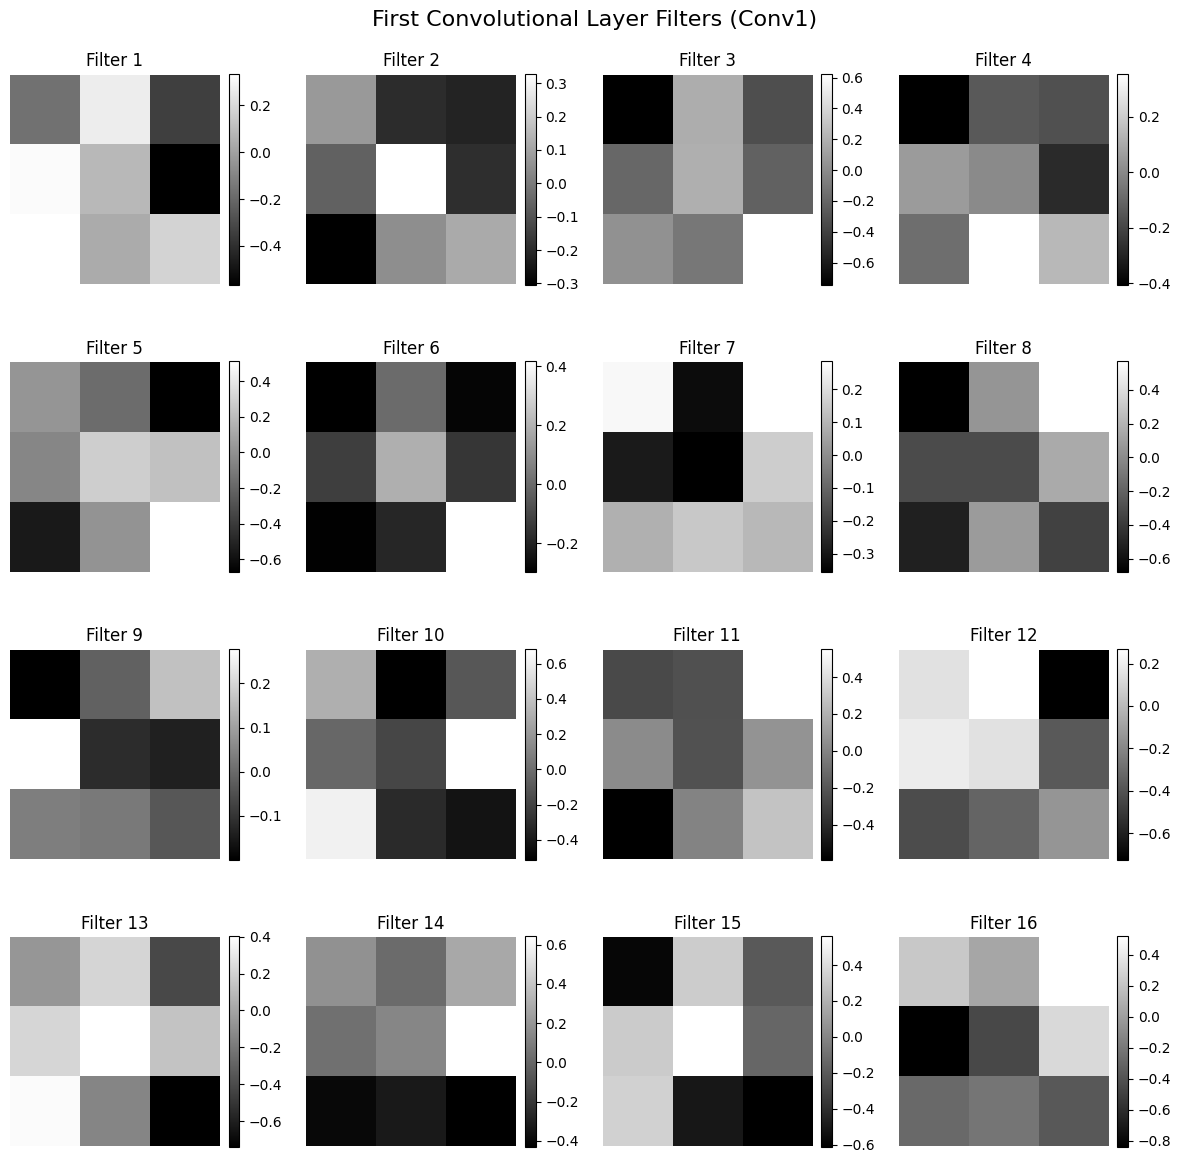

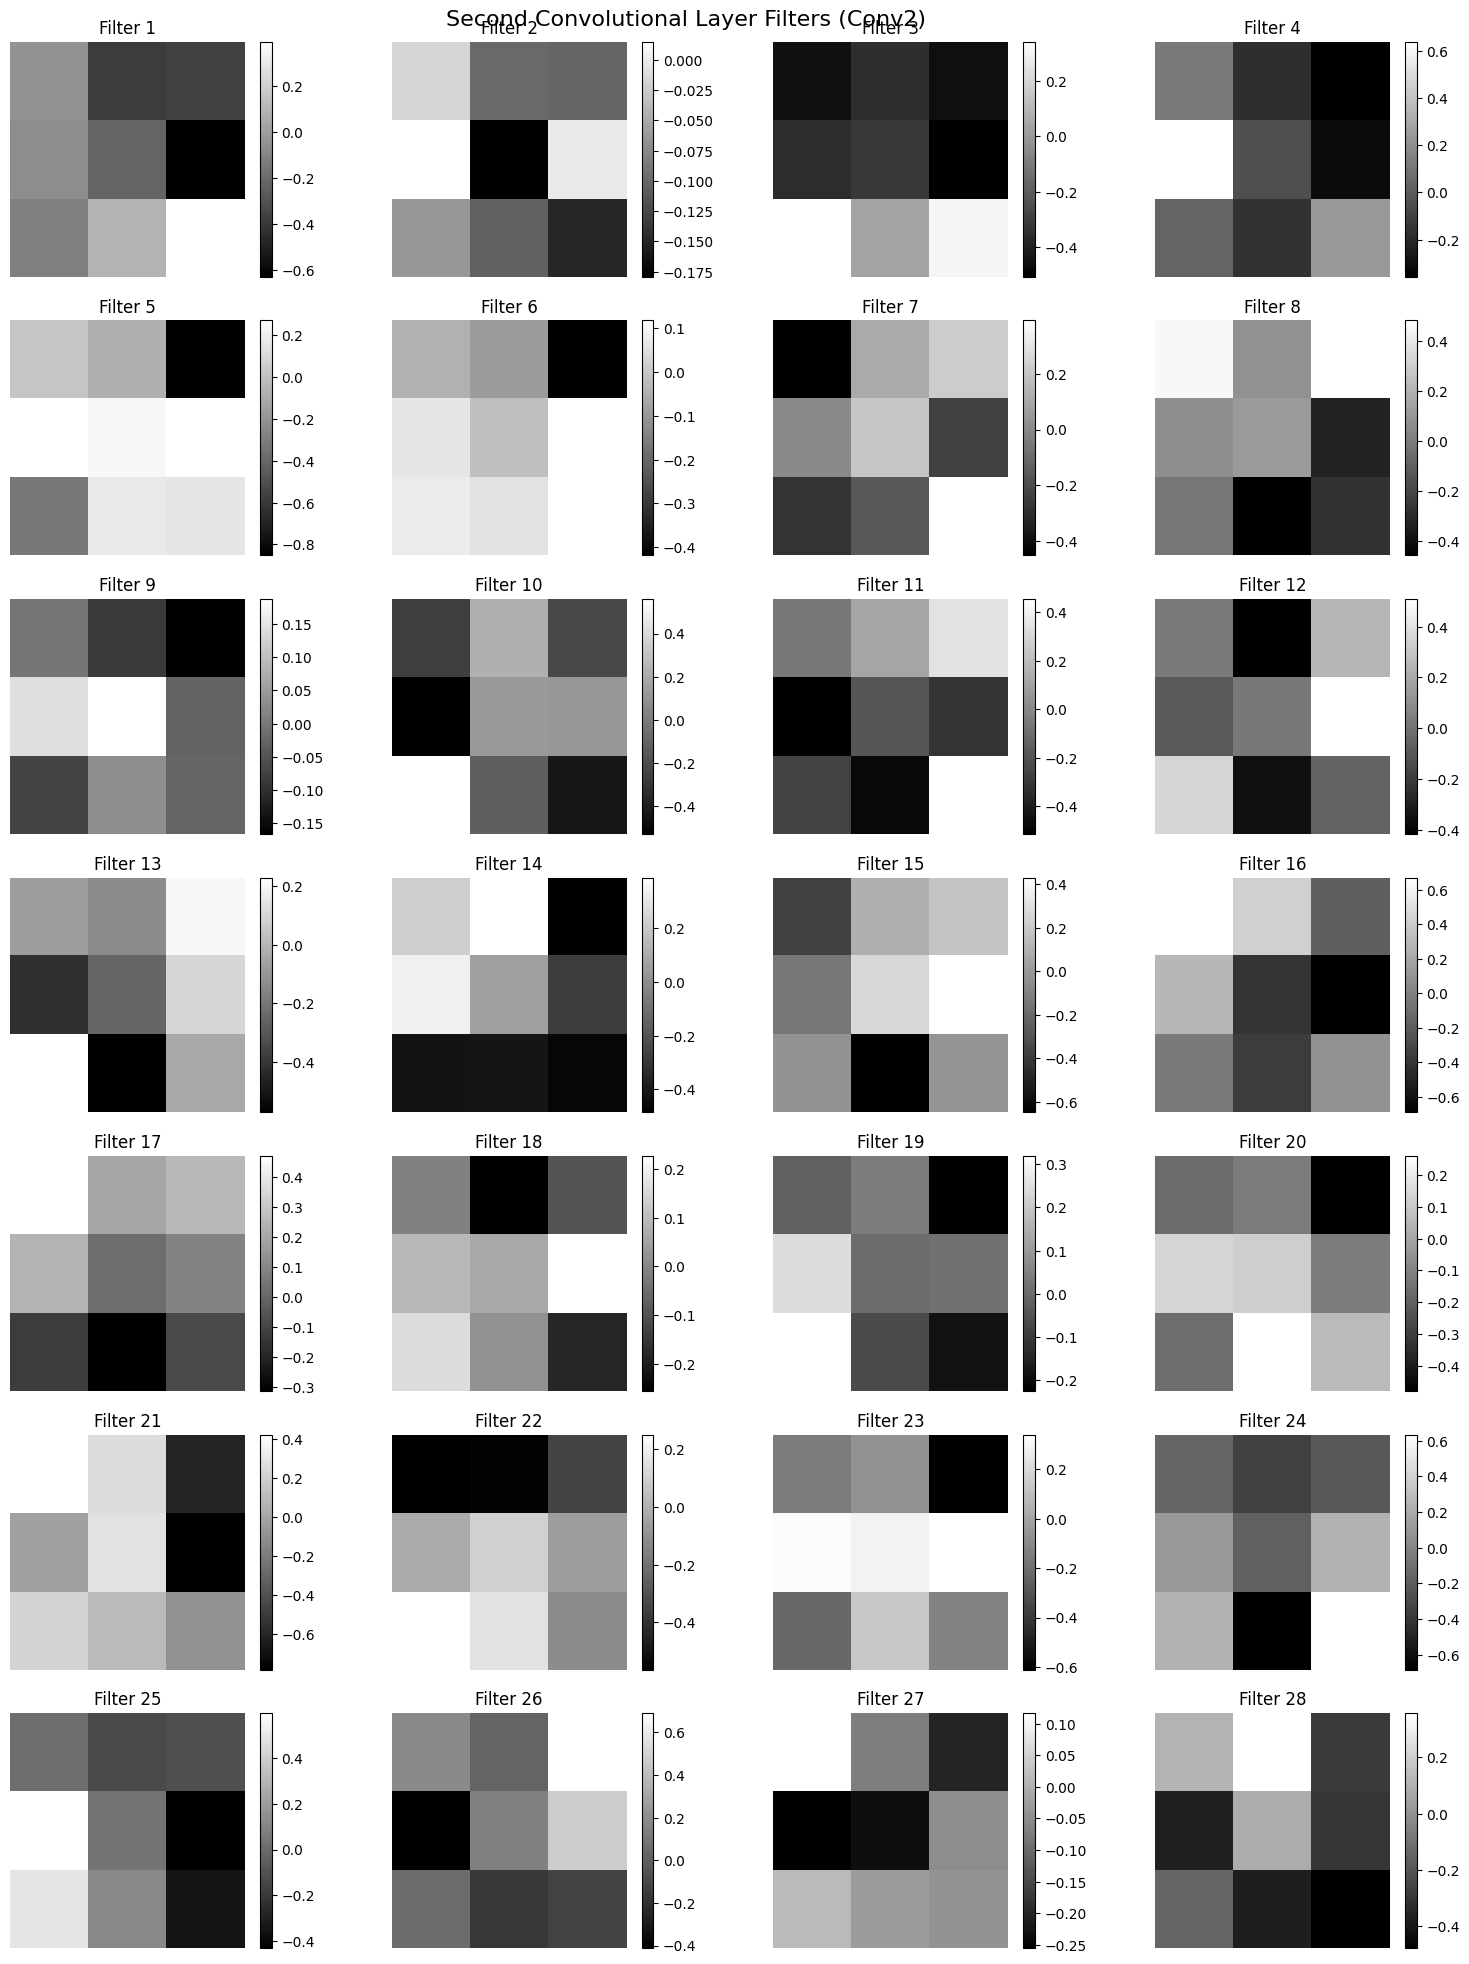

In [ ]:
# Visualize the trained convolutional layer filters
import matplotlib.pyplot as plt
import numpy as np

# Get the trained model's convolutional layer weights
conv1_weights = model.convblock1[0].weight.data.cpu().numpy()  # Conv2d layer inside convblock1
conv2_weights = model.convblock2[0].weight.data.cpu().numpy()  # Conv2d layer inside convblock2

print("Conv1 weights shape:", conv1_weights.shape)  # Should be (8, 1, 3, 3)
print("Conv2 weights shape:", conv2_weights.shape)  # Should be (16, 8, 3, 3)

# Visualize Conv1 filters (8 filters of 3x3)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle('First Convolutional Layer Filters (Conv1) - All 8', fontsize=16)

for i in range(8):
    ax = axes[i//4, i%4]
    # Conv1 has shape (8, 1, 3, 3), so we take [i, 0, :, :] for each filter
    filter_img = conv1_weights[i, 0, :, :]
    im = ax.imshow(filter_img, cmap='gray', interpolation='nearest')
    ax.set_title(f'Filter {i+1}')
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Visualize Conv2 filters (16 filters of 3x3, show first 8)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle('Second Convolutional Layer Filters (Conv2) - First 8', fontsize=16)

for i in range(8):
    ax = axes[i//4, i%4]
    # Conv2 has shape (16, 8, 3, 3), so we take [i, 0, :, :] for each filter (first channel)
    filter_img = conv2_weights[i, 0, :, :]
    im = ax.imshow(filter_img, cmap='gray', interpolation='nearest')
    ax.set_title(f'Filter {i+1}')
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

Sample image shape: torch.Size([1, 1, 28, 28])
Sample label: 8
Conv1 output shape: torch.Size([1, 28, 26, 26])
Conv2 output shape: torch.Size([1, 1, 24, 24])


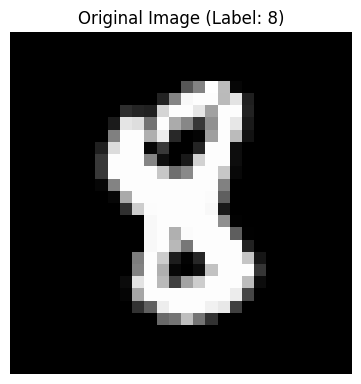

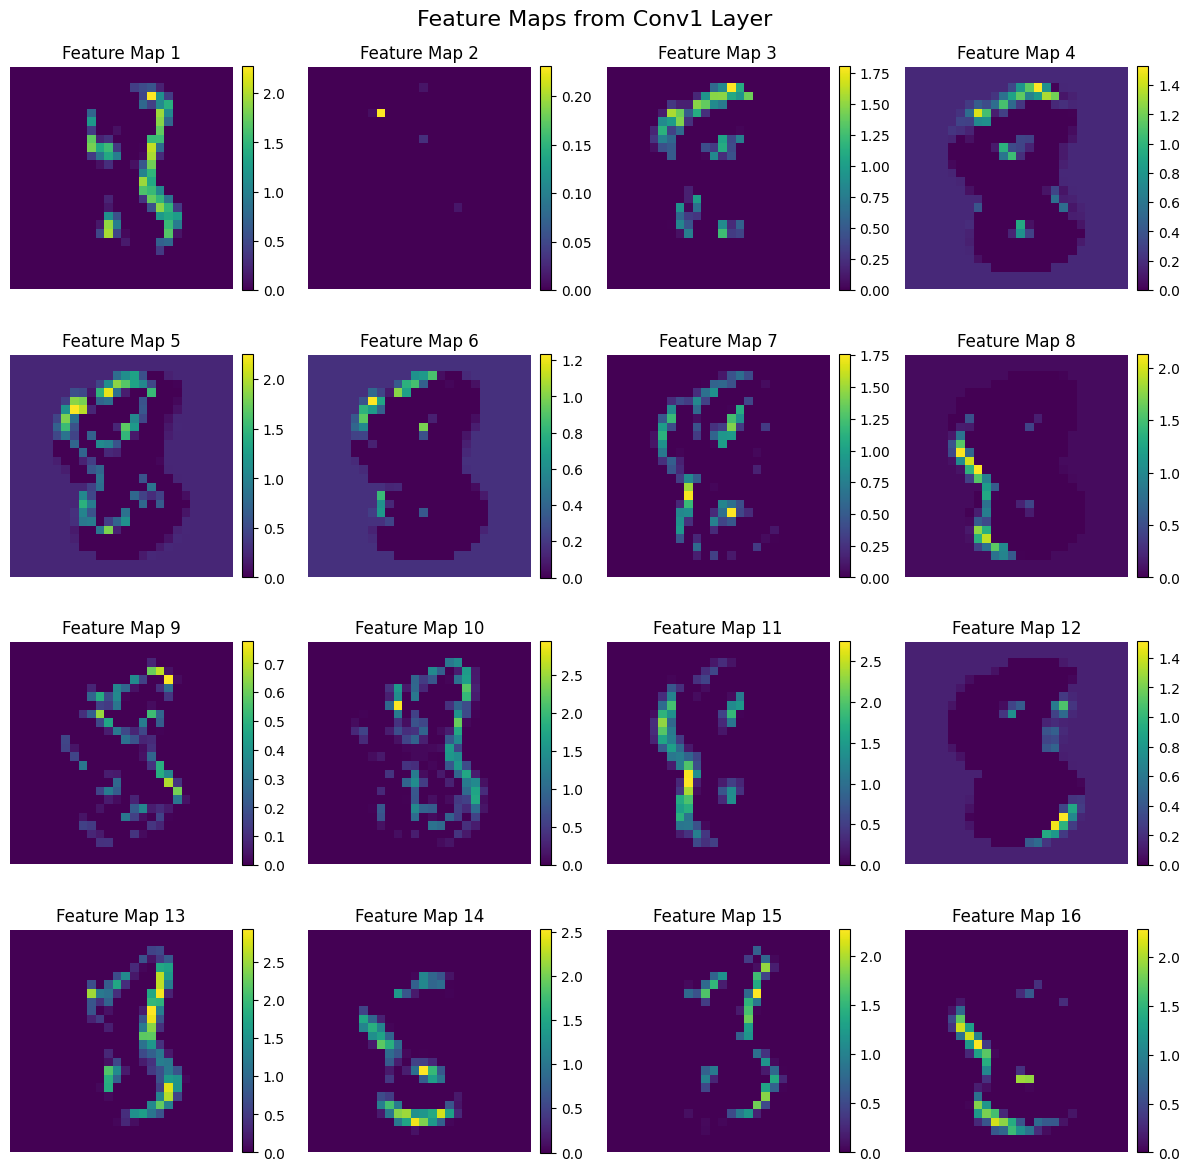

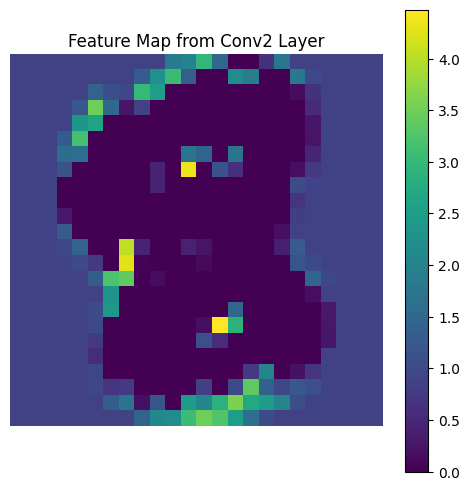

In [ ]:
# Visualize feature maps by passing a misclassified sample image through the network
def visualize_feature_maps(model, device, test_loader):
    model.eval()
    
    # Find a misclassified sample
    misclassified_sample = None
    misclassified_label = None
    misclassified_pred = None
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            # Find misclassified samples
            incorrect_mask = pred.squeeze() != target
            
            if incorrect_mask.any():
                # Take the first misclassified sample
                idx = incorrect_mask.nonzero(as_tuple=True)[0][0]
                misclassified_sample = data[idx:idx+1]  # Keep batch dimension
                misclassified_label = target[idx].cpu().item()
                misclassified_pred = pred[idx].cpu().item()
                break
    
    if misclassified_sample is None:
        print("No misclassified samples found in the test data!")
        return
    
    sample_image = misclassified_sample
    print(f"Misclassified sample shape: {sample_image.shape}")
    print(f"True label: {misclassified_label}, Predicted: {misclassified_pred}")
    
    # Display the original image
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(sample_image.cpu().squeeze(), cmap='gray')
    plt.title(f'Misclassified Image\nTrue: {misclassified_label} | Pred: {misclassified_pred}', color='red', fontweight='bold')
    plt.axis('off')
    
    # Get feature maps from all conv layers
    with torch.no_grad():
        conv1_output = F.relu(model.convblock1(sample_image))
        conv2_output = F.relu(model.convblock2(conv1_output))
        conv3_output = F.relu(model.convblock3(conv2_output))
        conv4_output = F.relu(model.convblock4(conv3_output))
        conv5_output = F.relu(model.convblock5(conv4_output))
    
    print(f"Conv1 output shape: {conv1_output.shape}")  # (1, 8, 26, 26)
    print(f"Conv2 output shape: {conv2_output.shape}")  # (1, 16, 24, 24)
    print(f"Conv3 output shape: {conv3_output.shape}")  # (1, 16, 24, 24)
    print(f"Conv4 output shape: {conv4_output.shape}")  # (1, 8, 22, 22)
    print(f"Conv5 output shape: {conv5_output.shape}")  # (1, 1, 22, 22)
    
    # Visualize feature maps from conv1 (8 channels)
    conv1_features = conv1_output.cpu().squeeze().numpy()
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle('Feature Maps from ConvBlock1 Layer (8 channels)', fontsize=16)
    
    for i in range(8):
        ax = axes[i//4, i%4]
        im = ax.imshow(conv1_features[i], cmap='viridis')
        ax.set_title(f'Feature Map {i+1}')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    # Visualize feature maps from conv2 (16 channels, show first 8)
    conv2_features = conv2_output.cpu().squeeze().numpy()
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle('Feature Maps from ConvBlock2 Layer (First 8 of 16)', fontsize=16)
    
    for i in range(8):
        ax = axes[i//4, i%4]
        im = ax.imshow(conv2_features[i], cmap='viridis')
        ax.set_title(f'Feature Map {i+1}')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    # Visualize feature maps from conv3 (16 channels, show first 8)
    conv3_features = conv3_output.cpu().squeeze().numpy()
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle('Feature Maps from ConvBlock3 Layer (First 8 of 16)', fontsize=16)
    
    for i in range(8):
        ax = axes[i//4, i%4]
        im = ax.imshow(conv3_features[i], cmap='viridis')
        ax.set_title(f'Feature Map {i+1}')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    # Visualize feature maps from conv4 (8 channels)
    conv4_features = conv4_output.cpu().squeeze().numpy()
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle('Feature Maps from ConvBlock4 Layer (8 channels)', fontsize=16)
    
    for i in range(8):
        ax = axes[i//4, i%4]
        im = ax.imshow(conv4_features[i], cmap='viridis')
        ax.set_title(f'Feature Map {i+1}')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    # Visualize the single feature map from conv5
    conv5_features = conv5_output.cpu().squeeze().numpy()  # Shape: (22, 22)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(conv5_features, cmap='viridis')
    plt.title('Feature Map from ConvBlock5 Layer (1 channel)')
    plt.colorbar()
    plt.axis('off')
    plt.show()

# Call the visualization function
visualize_feature_maps(model, device, test_loader)

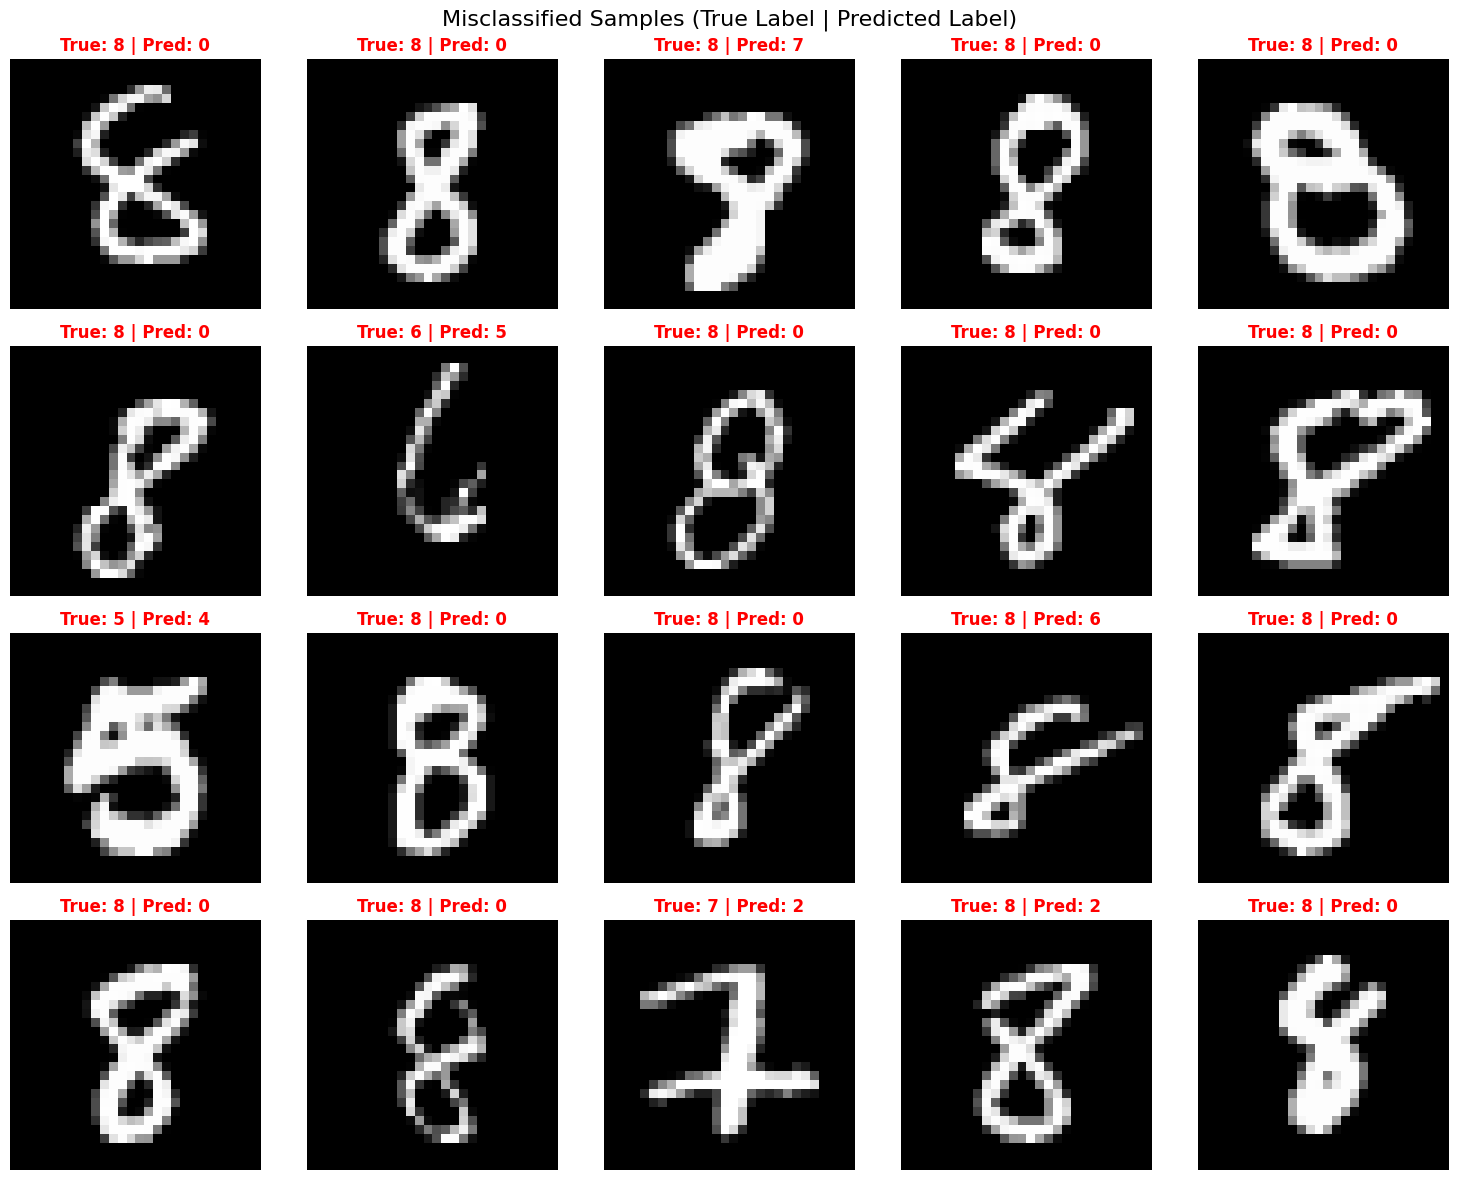

Found 20 misclassified samples out of the first few batches tested.


In [ ]:
# Visualize incorrectly predicted samples
def visualize_misclassified_samples(model, device, test_loader, num_samples=20):
    """
    Visualize samples that were incorrectly predicted by the model
    """
    model.eval()
    misclassified_images = []
    true_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            # Find misclassified samples
            incorrect_mask = pred.squeeze() != target
            
            if incorrect_mask.any():
                # Get misclassified samples from this batch
                misclassified_data = data[incorrect_mask]
                misclassified_targets = target[incorrect_mask]
                misclassified_preds = pred[incorrect_mask].squeeze()
                
                # Add to our collection
                for i in range(len(misclassified_data)):
                    if len(misclassified_images) < num_samples:
                        misclassified_images.append(misclassified_data[i].cpu())
                        true_labels.append(misclassified_targets[i].cpu().item())
                        predicted_labels.append(misclassified_preds[i].cpu().item())
            
            # Stop if we have enough samples
            if len(misclassified_images) >= num_samples:
                break
    
    # Plot the misclassified samples
    if len(misclassified_images) > 0:
        # Calculate grid dimensions
        cols = 5
        rows = (len(misclassified_images) + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
        fig.suptitle('Misclassified Samples (True Label | Predicted Label)', fontsize=16)
        
        for i in range(len(misclassified_images)):
            row, col = i // cols, i % cols
            ax = axes[row, col] if rows > 1 else axes[col]
            
            # Display the image
            ax.imshow(misclassified_images[i].squeeze(), cmap='gray')
            ax.set_title(f'True: {true_labels[i]} | Pred: {predicted_labels[i]}', 
                        color='red', fontweight='bold')
            ax.axis('off')
        
        # Hide unused subplots
        for i in range(len(misclassified_images), rows * cols):
            row, col = i // cols, i % cols
            ax = axes[row, col] if rows > 1 else axes[col]
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Found {len(misclassified_images)} misclassified samples out of the first few batches tested.")
    else:
        print("No misclassified samples found in the test data!")

# Call the function to visualize misclassified samples
visualize_misclassified_samples(model, device, test_loader, num_samples=20)

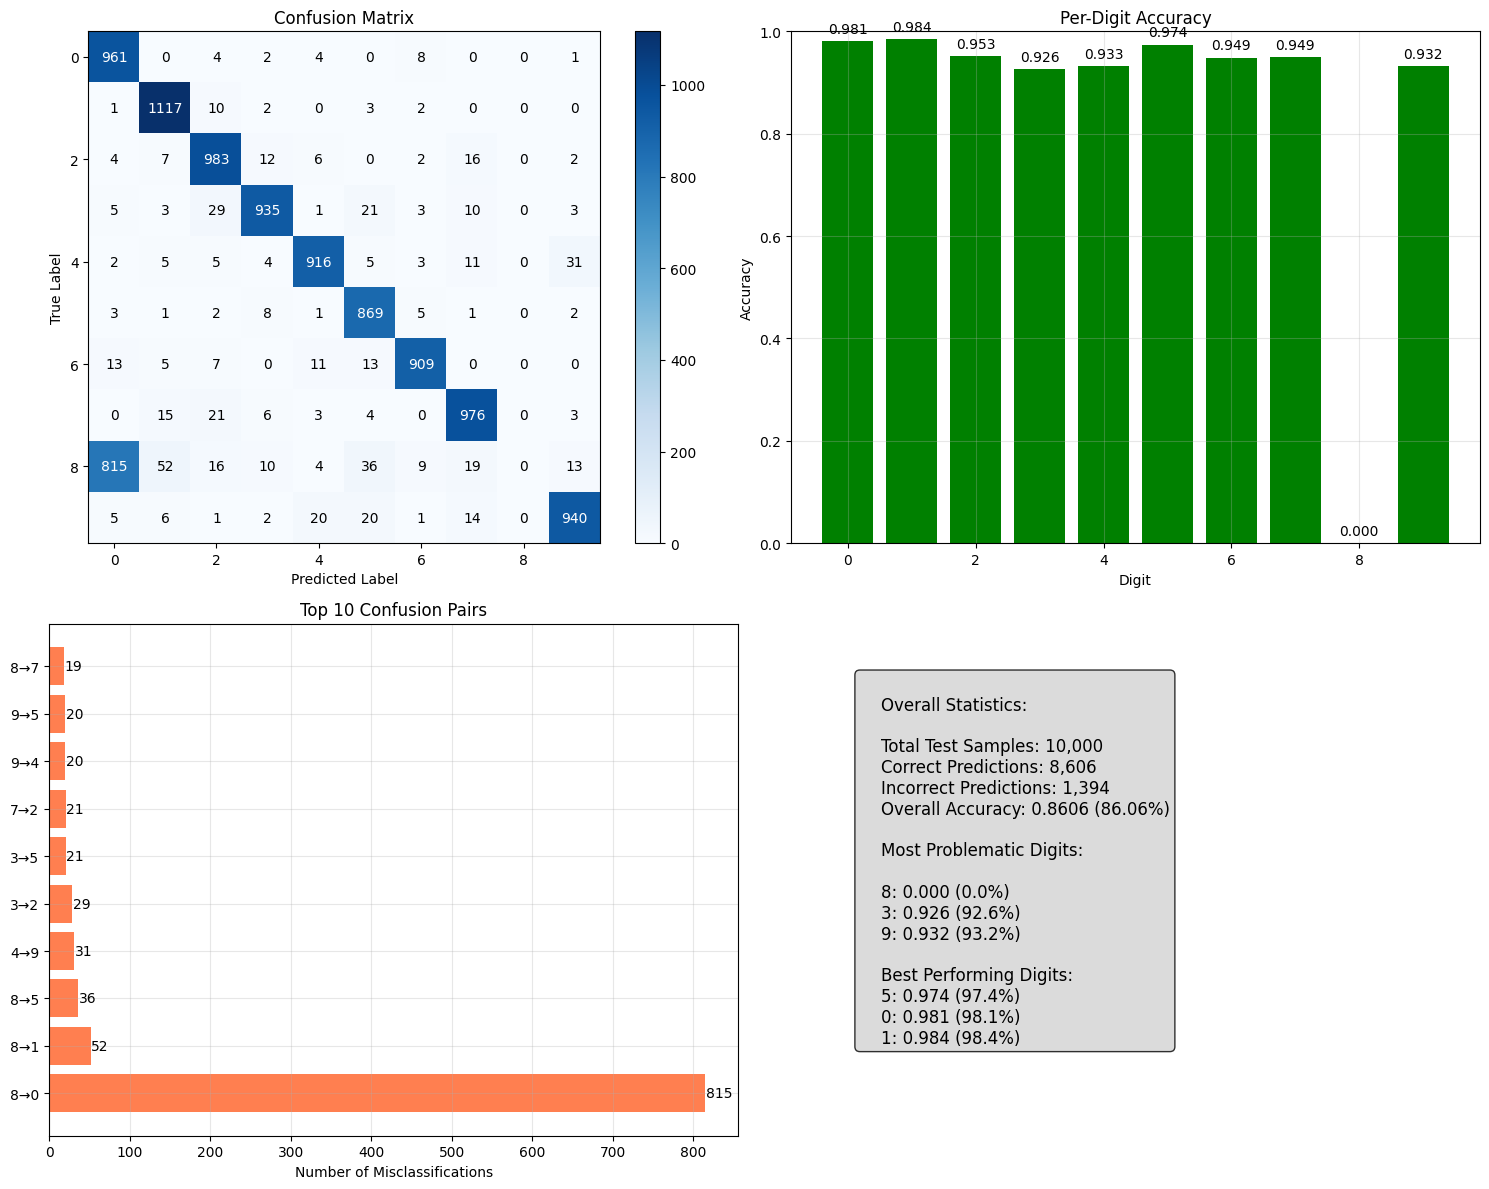

In [ ]:
# Detailed analysis of misclassification patterns
def analyze_misclassification_patterns(model, device, test_loader):
    """
    Analyze and visualize patterns in misclassifications
    """
    model.eval()
    
    # Initialize confusion matrix
    confusion_matrix = torch.zeros(10, 10)
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            
            all_predictions.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            
            # Update confusion matrix
            for t, p in zip(target.view(-1), pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    
    # Convert to numpy for easier handling
    confusion_matrix = confusion_matrix.numpy()
    
    # Calculate accuracy for each digit
    digit_accuracy = []
    for i in range(10):
        total_digit = confusion_matrix[i, :].sum()
        correct_digit = confusion_matrix[i, i]
        accuracy = correct_digit / total_digit if total_digit > 0 else 0
        digit_accuracy.append(accuracy)
    
    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Confusion Matrix
    ax1 = axes[0, 0]
    im1 = ax1.imshow(confusion_matrix, cmap='Blues')
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')
    
    # Add text annotations to confusion matrix
    for i in range(10):
        for j in range(10):
            text = ax1.text(j, i, int(confusion_matrix[i, j]),
                           ha="center", va="center", color="black" if confusion_matrix[i, j] < confusion_matrix.max()/2 else "white")
    
    plt.colorbar(im1, ax=ax1)
    
    # 2. Per-digit accuracy
    ax2 = axes[0, 1]
    bars = ax2.bar(range(10), digit_accuracy, color=['red' if acc < 0.9 else 'green' for acc in digit_accuracy])
    ax2.set_title('Per-Digit Accuracy')
    ax2.set_xlabel('Digit')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim(0, 1)
    ax2.grid(True, alpha=0.3)
    
    # Add accuracy values on bars
    for i, (bar, acc) in enumerate(zip(bars, digit_accuracy)):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.3f}', ha='center', va='bottom')
    
    # 3. Most confused pairs
    ax3 = axes[1, 0]
    
    # Find most common misclassifications (excluding correct predictions)
    confusion_pairs = []
    for i in range(10):
        for j in range(10):
            if i != j and confusion_matrix[i, j] > 0:
                confusion_pairs.append((i, j, confusion_matrix[i, j]))
    
    # Sort by frequency and take top 10
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    top_confusions = confusion_pairs[:10]
    
    if top_confusions:
        pair_labels = [f'{pair[0]}→{pair[1]}' for pair in top_confusions]
        pair_counts = [pair[2] for pair in top_confusions]
        
        bars = ax3.barh(range(len(pair_labels)), pair_counts, color='coral')
        ax3.set_yticks(range(len(pair_labels)))
        ax3.set_yticklabels(pair_labels)
        ax3.set_xlabel('Number of Misclassifications')
        ax3.set_title('Top 10 Confusion Pairs')
        ax3.grid(True, alpha=0.3)
        
        # Add count values on bars
        for i, (bar, count) in enumerate(zip(bars, pair_counts)):
            ax3.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                    f'{int(count)}', ha='left', va='center')
    
    # 4. Overall statistics
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    total_samples = len(all_targets)
    correct_predictions = sum(p == t for p, t in zip(all_predictions, all_targets))
    overall_accuracy = correct_predictions / total_samples
    total_errors = total_samples - correct_predictions
    
    stats_text = f"""
    Overall Statistics:
    
    Total Test Samples: {total_samples:,}
    Correct Predictions: {correct_predictions:,}
    Incorrect Predictions: {total_errors:,}
    Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)
    
    Most Problematic Digits:
    """
    
    # Find digits with lowest accuracy
    digit_acc_pairs = [(i, acc) for i, acc in enumerate(digit_accuracy)]
    digit_acc_pairs.sort(key=lambda x: x[1])
    
    for i, (digit, acc) in enumerate(digit_acc_pairs[:3]):
        stats_text += f"\n    {digit}: {acc:.3f} ({acc*100:.1f}%)"
    
    stats_text += f"\n\n    Best Performing Digits:"
    for i, (digit, acc) in enumerate(digit_acc_pairs[-3:]):
        stats_text += f"\n    {digit}: {acc:.3f} ({acc*100:.1f}%)"
    
    ax4.text(0.1, 0.9, stats_text, transform=ax4.transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return confusion_matrix, digit_accuracy

# Run the detailed analysis
confusion_matrix, digit_accuracy = analyze_misclassification_patterns(model, device, test_loader)


Misclassified Sample 1
True Label: 8, Predicted: 0


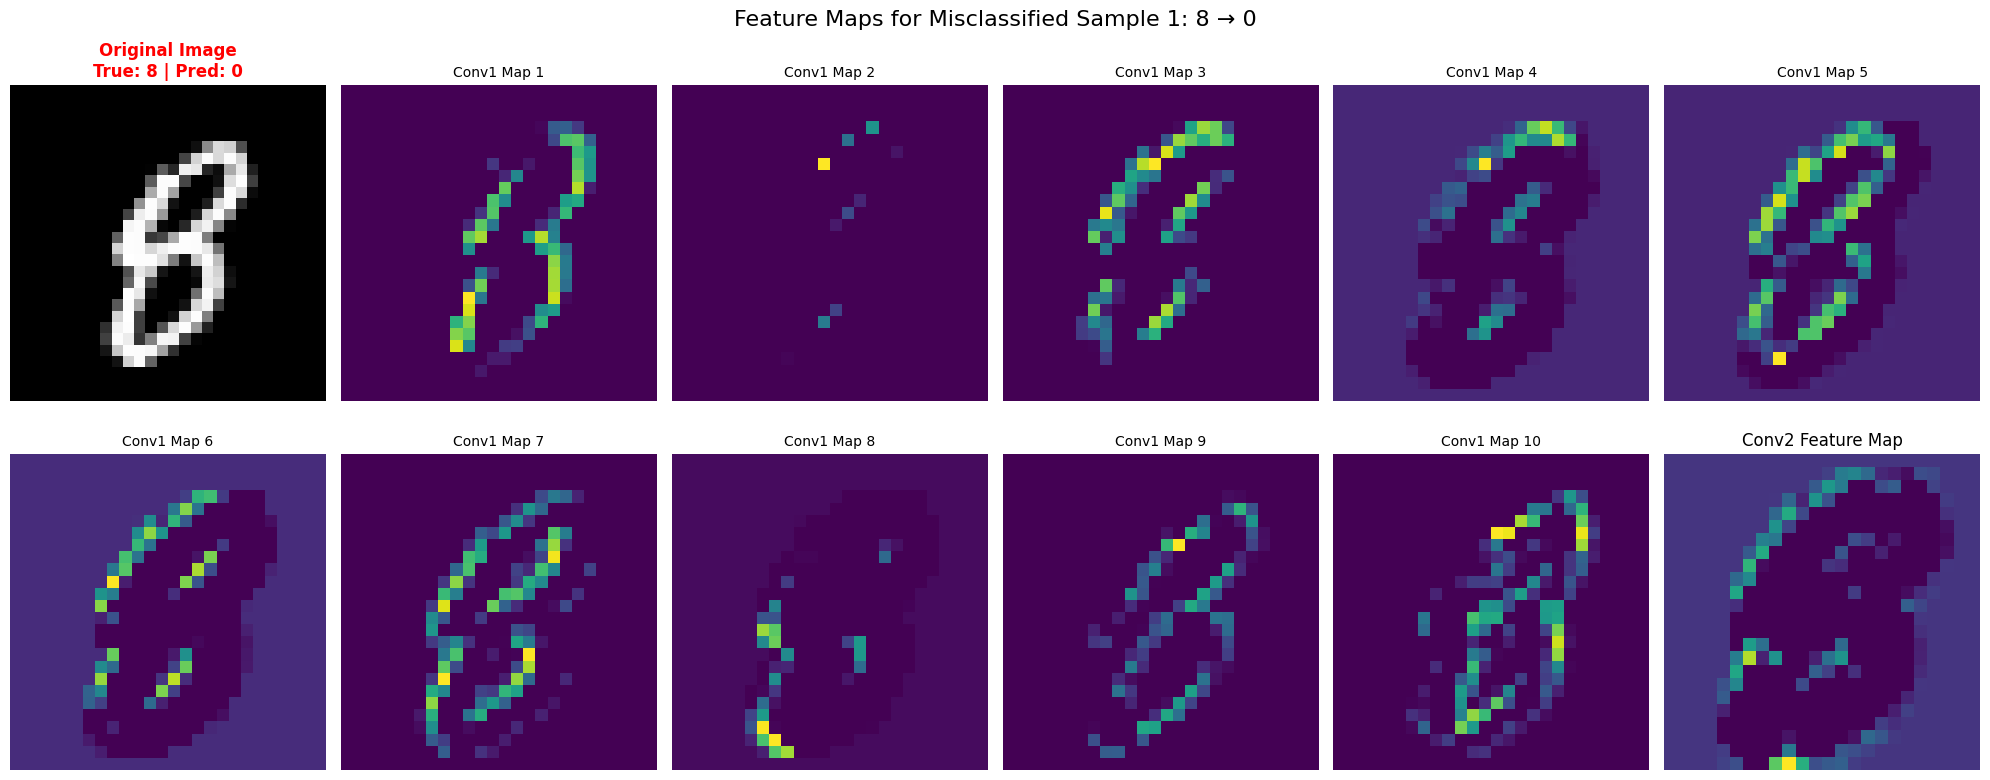

Feature Map Statistics for Sample 1:
Conv1 - Mean activation: 0.1155, Max: 3.0185
Conv2 - Mean activation: 0.6630, Max: 5.7361

Misclassified Sample 2
True Label: 8, Predicted: 0


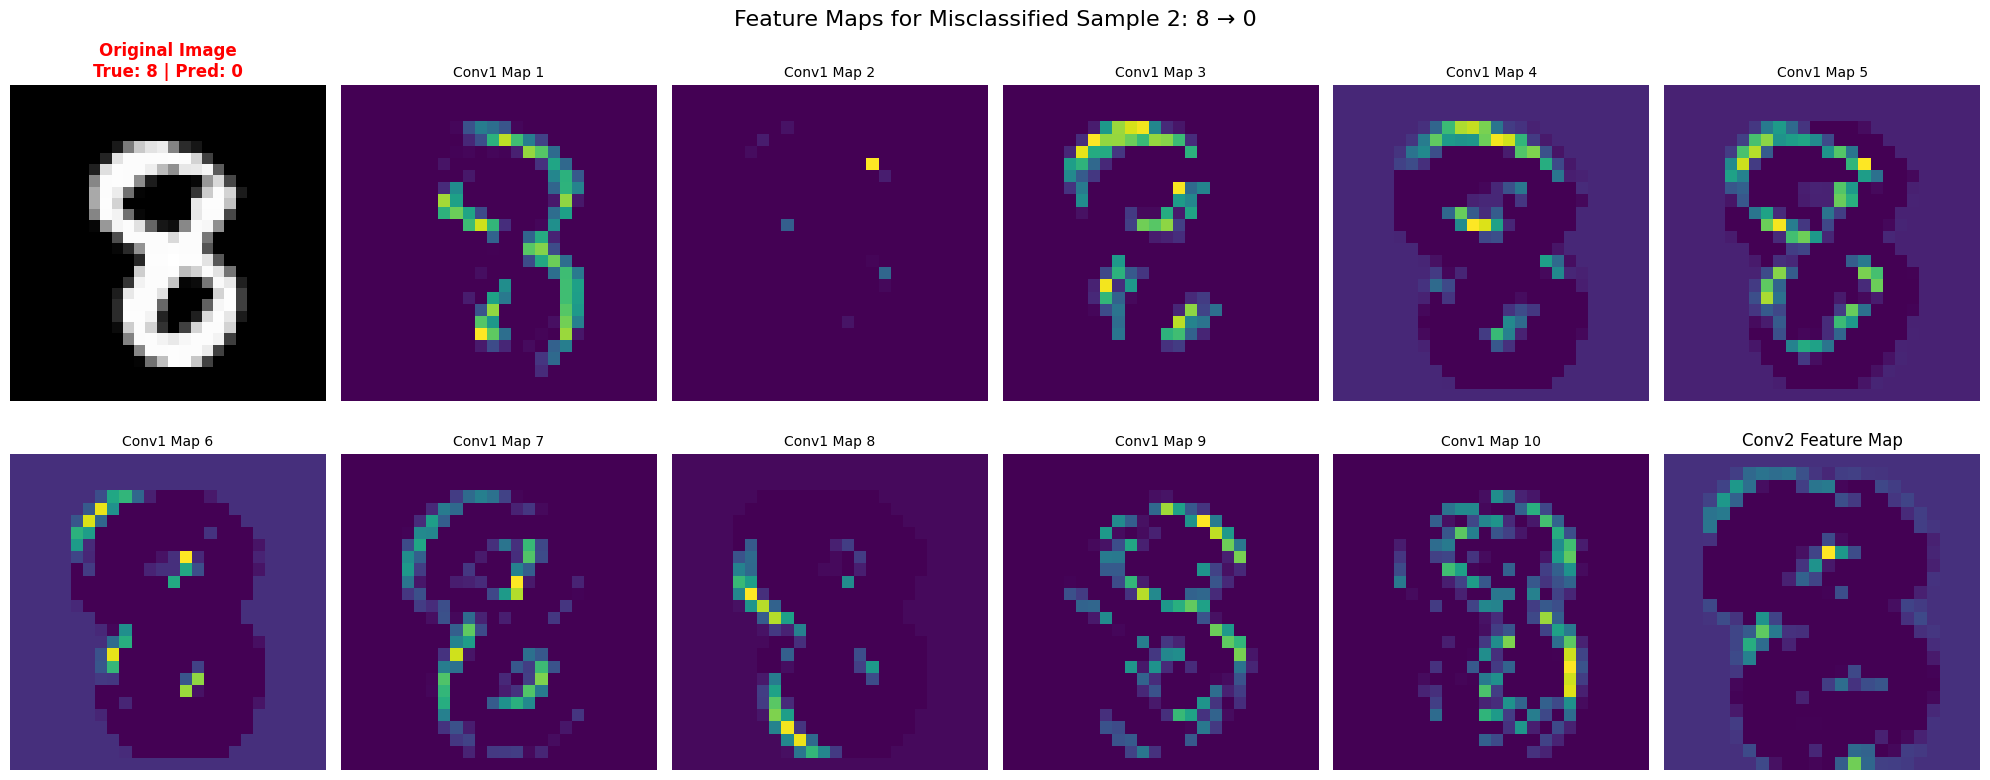

Feature Map Statistics for Sample 2:
Conv1 - Mean activation: 0.1159, Max: 3.2933
Conv2 - Mean activation: 0.6107, Max: 6.3889

Misclassified Sample 3
True Label: 8, Predicted: 0


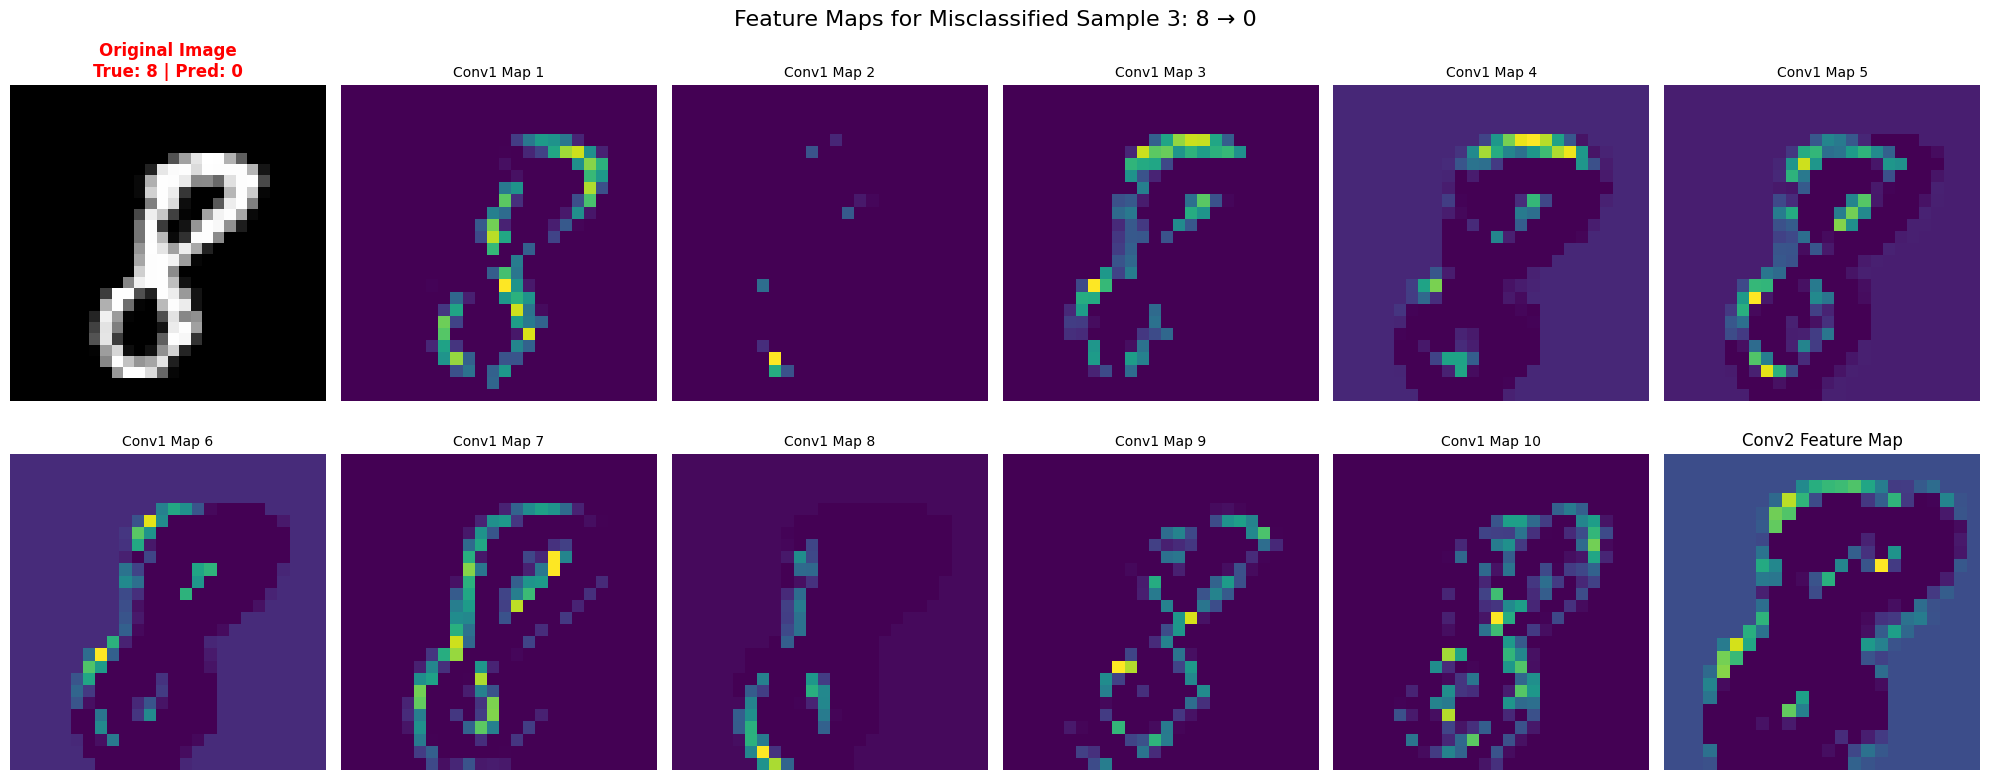

Feature Map Statistics for Sample 3:
Conv1 - Mean activation: 0.1100, Max: 3.1491
Conv2 - Mean activation: 0.6423, Max: 3.7285


In [ ]:
# Visualize feature maps for wrongly classified samples
def visualize_misclassified_feature_maps(model, device, test_loader, num_samples=4):
    """
    Visualize feature maps for misclassified samples to understand model failures
    """
    model.eval()
    misclassified_data = []
    misclassified_info = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            # Find misclassified samples
            incorrect_mask = pred.squeeze() != target
            
            if incorrect_mask.any():
                # Get misclassified samples from this batch
                wrong_data = data[incorrect_mask]
                wrong_targets = target[incorrect_mask]
                wrong_preds = pred[incorrect_mask].squeeze()
                
                # Add to our collection
                for i in range(len(wrong_data)):
                    if len(misclassified_data) < num_samples:
                        misclassified_data.append(wrong_data[i:i+1])  # Keep batch dimension
                        misclassified_info.append({
                            'true_label': wrong_targets[i].cpu().item(),
                            'pred_label': wrong_preds[i].cpu().item()
                        })
            
            # Stop if we have enough samples
            if len(misclassified_data) >= num_samples:
                break
    
    if len(misclassified_data) == 0:
        print("No misclassified samples found!")
        return
    
    # Process each misclassified sample
    for idx, (sample, info) in enumerate(zip(misclassified_data, misclassified_info)):
        print(f"\n{'='*60}")
        print(f"Misclassified Sample {idx+1}")
        print(f"True Label: {info['true_label']}, Predicted: {info['pred_label']}")
        print(f"{'='*60}")
        
        # Get feature maps
        with torch.no_grad():
            conv1_output = F.relu(model.convblock1(sample))
            conv2_output = F.relu(model.convblock2(conv1_output))
        
        # Create a large figure for this sample
        fig = plt.figure(figsize=(20, 12))
        
        # 1. Original image
        plt.subplot(3, 6, 1)
        plt.imshow(sample.cpu().squeeze(), cmap='gray')
        plt.title(f'Original Image\nTrue: {info["true_label"]} | Pred: {info["pred_label"]}', 
                 fontsize=12, color='red', fontweight='bold')
        plt.axis('off')
        
        # 2. Show first 8 Conv1 feature maps (2 rows of 4)
        conv1_features = conv1_output.cpu().squeeze().numpy()  # Shape: (8, 26, 26)
        
        for i in range(8):
            plt.subplot(3, 6, i+2)
            plt.imshow(conv1_features[i], cmap='viridis')
            plt.title(f'Conv1 Map {i+1}', fontsize=10)
            plt.axis('off')
        
        # 3. Conv2 feature map (first one of 16)
        plt.subplot(3, 6, 10)
        conv2_features = conv2_output.cpu().squeeze().numpy()  # Shape: (16, 24, 24)
        plt.imshow(conv2_features[0], cmap='viridis')
        plt.title('Conv2 Feature Map 1', fontsize=12)
        plt.axis('off')
        
        plt.suptitle(f'Feature Maps for Misclassified Sample {idx+1}: {info["true_label"]} → {info["pred_label"]}', 
                    fontsize=16, y=0.98)
        plt.tight_layout()
        plt.show()
        
        # Show activation statistics for this sample
        print(f"Feature Map Statistics for Sample {idx+1}:")
        print(f"ConvBlock1 - Mean activation: {conv1_features.mean():.4f}, Max: {conv1_features.max():.4f}")
        print(f"ConvBlock2 - Mean activation: {conv2_features.mean():.4f}, Max: {conv2_features.max():.4f}")

# Call the function to visualize feature maps for misclassified samples
visualize_misclassified_feature_maps(model, device, test_loader, num_samples=3)

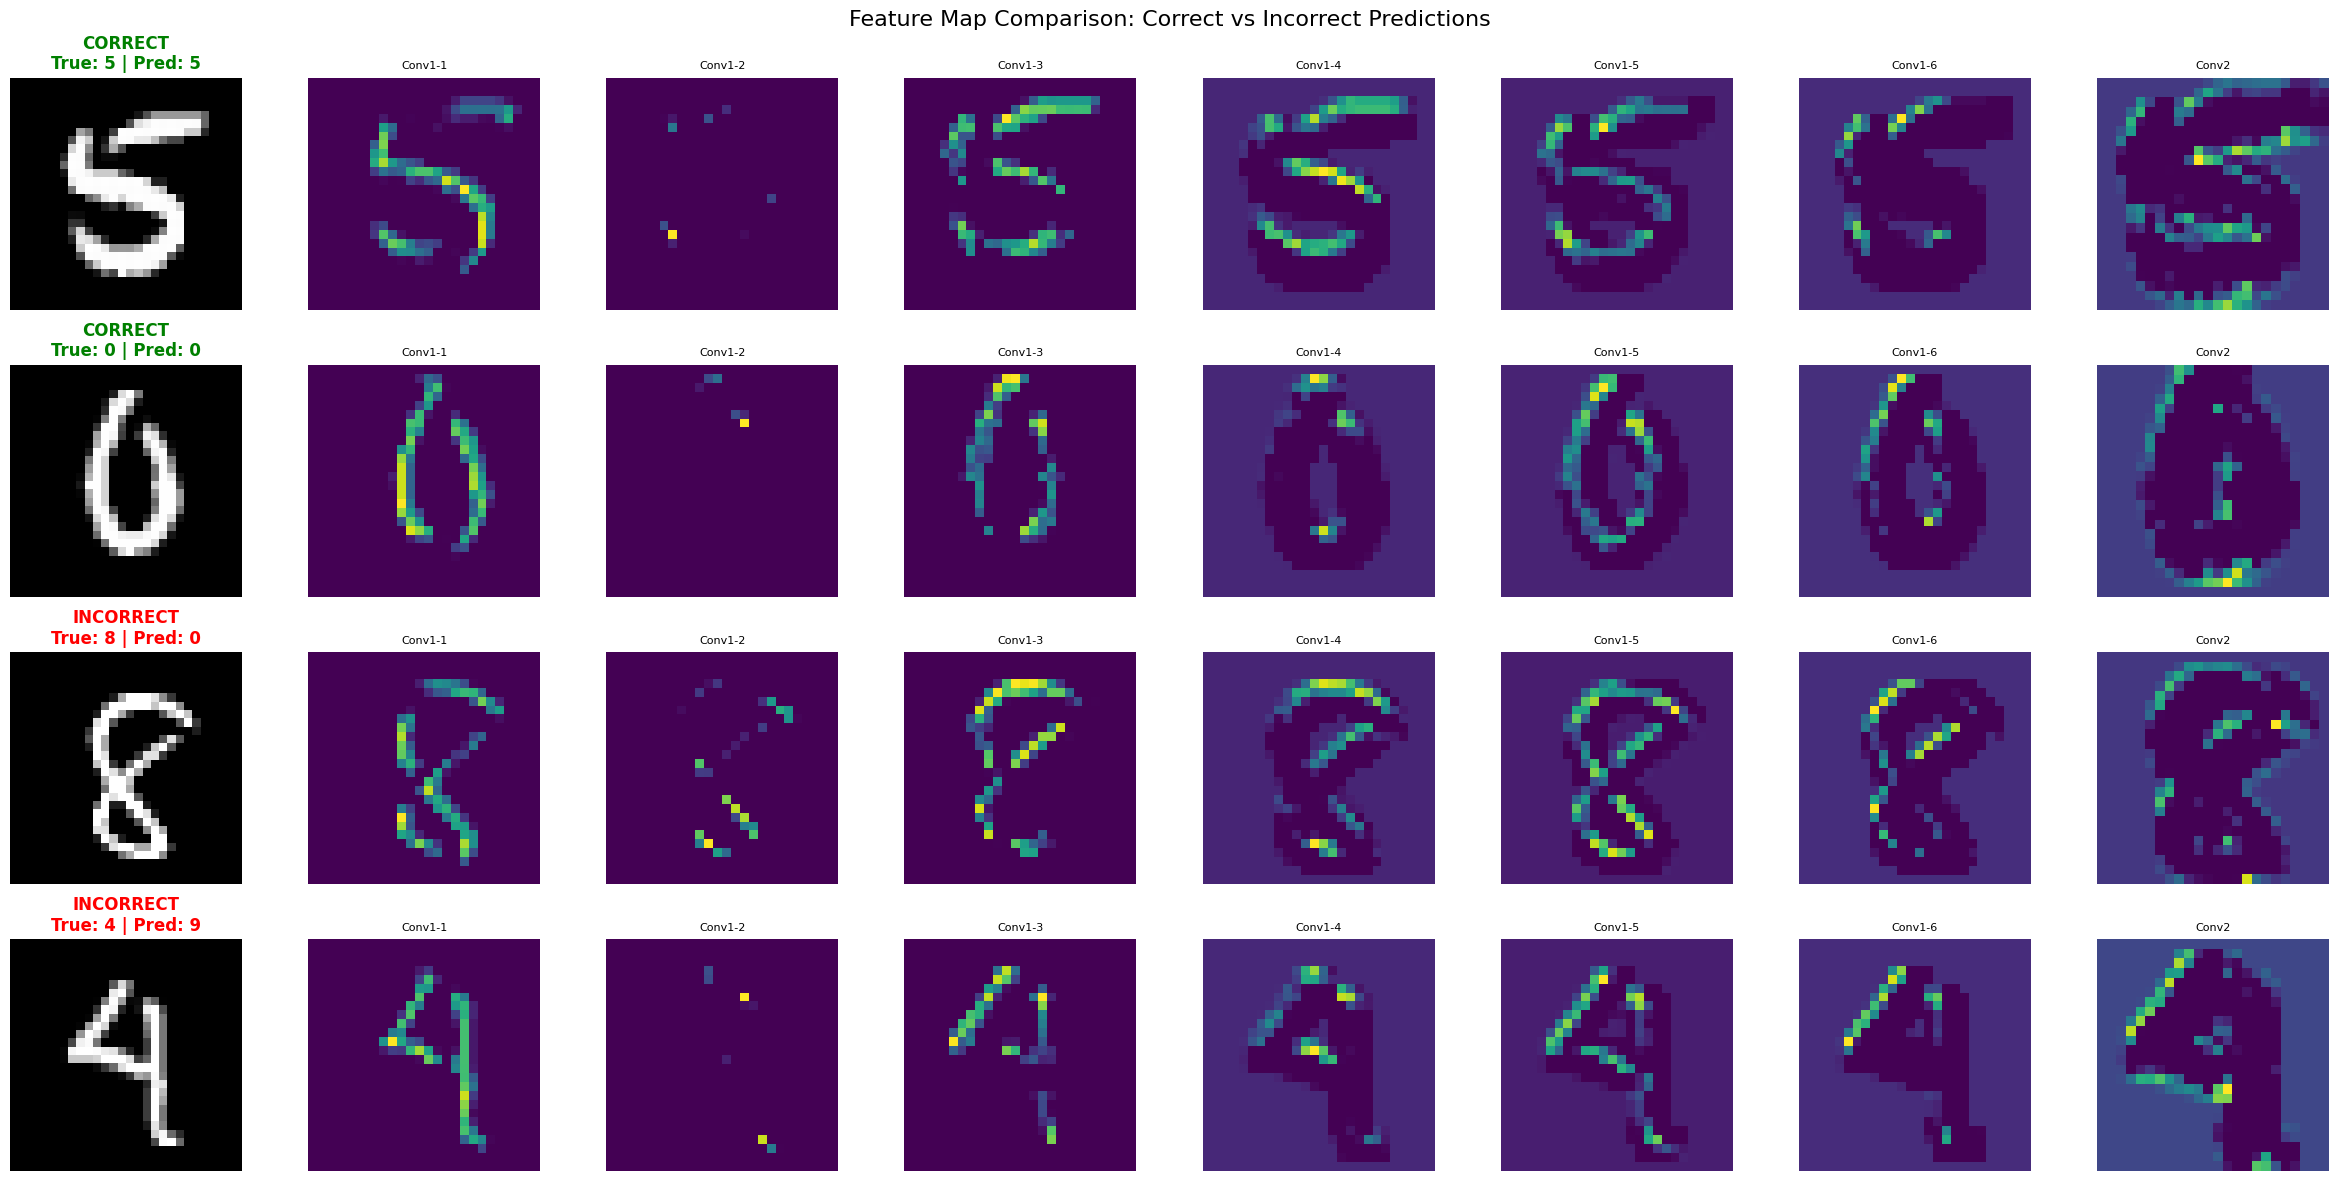


Activation Statistics Comparison:
Correct Sample 1 - Conv1 mean: 0.1237, Conv2 mean: 0.7406
Correct Sample 2 - Conv1 mean: 0.1077, Conv2 mean: 0.6289
Incorrect Sample 1 - Conv1 mean: 0.1260, Conv2 mean: 0.6752
Incorrect Sample 2 - Conv1 mean: 0.1031, Conv2 mean: 0.6877


In [ ]:
# Compare feature maps: Correct vs Incorrect predictions
def compare_correct_vs_incorrect_feature_maps(model, device, test_loader):
    """
    Compare feature maps between correctly and incorrectly classified samples
    """
    model.eval()
    correct_samples = []
    incorrect_samples = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            # Find correct and incorrect samples
            correct_mask = pred.squeeze() == target
            incorrect_mask = pred.squeeze() != target
            
            # Collect correct samples
            if correct_mask.any() and len(correct_samples) < 2:
                correct_data = data[correct_mask]
                correct_targets = target[correct_mask]
                correct_preds = pred[correct_mask].squeeze()
                
                for i in range(min(2-len(correct_samples), len(correct_data))):
                    correct_samples.append({
                        'data': correct_data[i:i+1],
                        'true_label': correct_targets[i].cpu().item(),
                        'pred_label': correct_preds[i].cpu().item()
                    })
            
            # Collect incorrect samples
            if incorrect_mask.any() and len(incorrect_samples) < 2:
                wrong_data = data[incorrect_mask]
                wrong_targets = target[incorrect_mask]
                wrong_preds = pred[incorrect_mask].squeeze()
                
                for i in range(min(2-len(incorrect_samples), len(wrong_data))):
                    incorrect_samples.append({
                        'data': wrong_data[i:i+1],
                        'true_label': wrong_targets[i].cpu().item(),
                        'pred_label': wrong_preds[i].cpu().item()
                    })
            
            # Stop if we have enough samples
            if len(correct_samples) >= 2 and len(incorrect_samples) >= 2:
                break
    
    # Create comparison visualization
    fig, axes = plt.subplots(4, 8, figsize=(24, 12))
    fig.suptitle('Feature Map Comparison: Correct vs Incorrect Predictions', fontsize=16)
    
    # Process correct samples
    for sample_idx, sample in enumerate(correct_samples):
        with torch.no_grad():
            conv1_output = F.relu(model.convblock1(sample['data']))
            conv2_output = F.relu(model.convblock2(conv1_output))
        
        conv1_features = conv1_output.cpu().squeeze().numpy()
        conv2_features = conv2_output.cpu().squeeze().numpy()
        
        row = sample_idx
        
        # Original image
        axes[row, 0].imshow(sample['data'].cpu().squeeze(), cmap='gray')
        axes[row, 0].set_title(f'CORRECT\nTrue: {sample["true_label"]} | Pred: {sample["pred_label"]}', 
                              color='green', fontweight='bold')
        axes[row, 0].axis('off')
        
        # Conv1 feature maps (first 6 of 8)
        for i in range(6):
            axes[row, i+1].imshow(conv1_features[i], cmap='viridis')
            axes[row, i+1].set_title(f'Conv1-{i+1}', fontsize=8)
            axes[row, i+1].axis('off')
        
        # Conv2 feature map (first one of 16)
        axes[row, 7].imshow(conv2_features[0], cmap='viridis')
        axes[row, 7].set_title('Conv2-1', fontsize=8)
        axes[row, 7].axis('off')
    
    # Process incorrect samples
    for sample_idx, sample in enumerate(incorrect_samples):
        with torch.no_grad():
            conv1_output = F.relu(model.convblock1(sample['data']))
            conv2_output = F.relu(model.convblock2(conv1_output))
        
        conv1_features = conv1_output.cpu().squeeze().numpy()
        conv2_features = conv2_output.cpu().squeeze().numpy()
        
        row = sample_idx + 2  # Offset by 2 to place below correct samples
        
        # Original image
        axes[row, 0].imshow(sample['data'].cpu().squeeze(), cmap='gray')
        axes[row, 0].set_title(f'INCORRECT\nTrue: {sample["true_label"]} | Pred: {sample["pred_label"]}', 
                              color='red', fontweight='bold')
        axes[row, 0].axis('off')
        
        # Conv1 feature maps (first 6 of 8)
        for i in range(6):
            axes[row, i+1].imshow(conv1_features[i], cmap='viridis')
            axes[row, i+1].set_title(f'Conv1-{i+1}', fontsize=8)
            axes[row, i+1].axis('off')
        
        # Conv2 feature map (first one of 16)
        axes[row, 7].imshow(conv2_features[0], cmap='viridis')
        axes[row, 7].set_title('Conv2-1', fontsize=8)
        axes[row, 7].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print activation statistics comparison
    print("\nActivation Statistics Comparison:")
    print("=" * 50)
    
    for i, sample in enumerate(correct_samples):
        with torch.no_grad():
            conv1_out = F.relu(model.convblock1(sample['data']))
            conv2_out = F.relu(model.convblock2(conv1_out))
        conv1_np = conv1_out.cpu().squeeze().numpy()
        conv2_np = conv2_out.cpu().squeeze().numpy()
        print(f"Correct Sample {i+1} - Conv1 mean: {conv1_np.mean():.4f}, Conv2 mean: {conv2_np.mean():.4f}")
    
    for i, sample in enumerate(incorrect_samples):
        with torch.no_grad():
            conv1_out = F.relu(model.convblock1(sample['data']))
            conv2_out = F.relu(model.convblock2(conv1_out))
        conv1_np = conv1_out.cpu().squeeze().numpy()
        conv2_np = conv2_out.cpu().squeeze().numpy()
        print(f"Incorrect Sample {i+1} - Conv1 mean: {conv1_np.mean():.4f}, Conv2 mean: {conv2_np.mean():.4f}")

# Call the comparison function
compare_correct_vs_incorrect_feature_maps(model, device, test_loader)

AttributeError: 'Net' object has no attribute 'conv1'

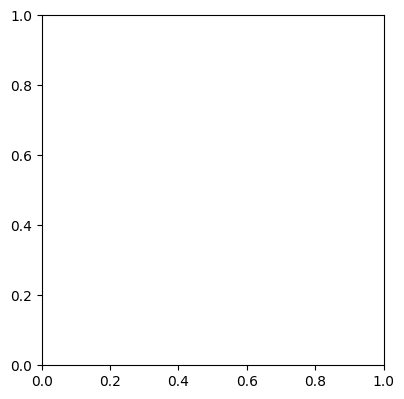

In [ ]:
# Analyze and visualize weight distributions
def analyze_layer_weights(model):
    """Analyze the distribution of weights in each layer"""
    
    plt.figure(figsize=(15, 10))
    
    # Conv1 weights analysis
    plt.subplot(2, 3, 1)
    conv1_weights_flat = model.convblock1[0].weight.data.cpu().numpy().flatten()
    plt.hist(conv1_weights_flat, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.title('ConvBlock1 Weights Distribution')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # Conv1 bias analysis
    plt.subplot(2, 3, 2)
    conv1_bias = model.convblock1[0].bias.data.cpu().numpy()
    plt.bar(range(len(conv1_bias)), conv1_bias, color='lightblue', edgecolor='black')
    plt.title('ConvBlock1 Bias Values')
    plt.xlabel('Filter Index')
    plt.ylabel('Bias Value')
    plt.grid(True, alpha=0.3)
    
    # Conv2 weights analysis
    plt.subplot(2, 3, 3)
    conv2_weights_flat = model.convblock2[0].weight.data.cpu().numpy().flatten()
    plt.hist(conv2_weights_flat, bins=50, alpha=0.7, color='red', edgecolor='black')
    plt.title('ConvBlock2 Weights Distribution')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # Conv2 bias analysis
    plt.subplot(2, 3, 4)
    conv2_bias = model.convblock2[0].bias.data.cpu().numpy()
    plt.bar(range(len(conv2_bias)), conv2_bias, color='lightcoral', edgecolor='black')
    plt.title('ConvBlock2 Bias Values')
    plt.xlabel('Filter Index')
    plt.ylabel('Bias Value')
    plt.grid(True, alpha=0.3)
    
    # FC1 weights analysis
    plt.subplot(2, 3, 5)
    fc1_weights_flat = model.fc1.weight.data.cpu().numpy().flatten()
    plt.hist(fc1_weights_flat, bins=50, alpha=0.7, color='green', edgecolor='black')
    plt.title('FC1 Weights Distribution')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # FC1 bias analysis
    plt.subplot(2, 3, 6)
    fc1_bias = model.fc1.bias.data.cpu().numpy()
    plt.bar(range(len(fc1_bias)), fc1_bias, color='lightgreen', edgecolor='black')
    plt.title('FC1 Bias Values (Output Classes)')
    plt.xlabel('Class Index')
    plt.ylabel('Bias Value')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("Layer Weight Statistics:")
    print("-" * 50)
    print(f"ConvBlock1 - Mean: {conv1_weights_flat.mean():.4f}, Std: {conv1_weights_flat.std():.4f}")
    print(f"ConvBlock1 - Min: {conv1_weights_flat.min():.4f}, Max: {conv1_weights_flat.max():.4f}")
    print(f"ConvBlock2 - Mean: {conv2_weights_flat.mean():.4f}, Std: {conv2_weights_flat.std():.4f}")
    print(f"ConvBlock2 - Min: {conv2_weights_flat.min():.4f}, Max: {conv2_weights_flat.max():.4f}")
    print(f"FC1 - Mean: {fc1_weights_flat.mean():.4f}, Std: {fc1_weights_flat.std():.4f}")
    print(f"FC1 - Min: {fc1_weights_flat.min():.4f}, Max: {fc1_weights_flat.max():.4f}")

# Analyze the trained model weights
analyze_layer_weights(model)